In [2]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, csc_matrix

# Loading the data and preprocessing it

In [ ]:
movies = pd.read_csv('ml-1m/ml-1m/movies.dat', sep='::', header=None, engine='python', encoding='ISO-8859-1', names=['MovieID', 'Title', 'Genres'])
ratings = pd.read_csv('ml-1m/ml-1m/ratings.dat', sep='::', header=None, engine='python', encoding='ISO-8859-1', names=['UserID', 'MovieID', 'Rating', 'Timestamp'])
users = pd.read_csv('ml-1m/ml-1m/users.dat', sep='::', header=None, engine='python', encoding='ISO-8859-1', names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])

# Rebase IDs to be contiguous integers 0...N-1 (useful for matrix indexing)
user2idx = {old: new for new, old in enumerate(users['UserID'].unique())}
movie2idx = {old: new for new, old in enumerate(movies['MovieID'].unique())}

users['UserID'] = users['UserID'].map(user2idx)
movies['MovieID'] = movies['MovieID'].map(movie2idx)
ratings['UserID'] = ratings['UserID'].map(user2idx)
ratings['MovieID'] = ratings['MovieID'].map(movie2idx)

print('Movies shape:', movies.shape)
print(movies.head())
print('\n')

movies['Genres'] = movies['Genres'].str.split('|').apply(lambda x: set(x))
genres_set = set().union(*movies['Genres'])

print('Ratings shape:', ratings.shape)
print(ratings.head())
print('\n')

print('Users shape:', users.shape)
print(users.head())
print('\n')

print('Genres:', genres_set)

Movies shape: (3883, 3)
   MovieID                               Title                        Genres
0        0                    Toy Story (1995)   Animation|Children's|Comedy
1        1                      Jumanji (1995)  Adventure|Children's|Fantasy
2        2             Grumpier Old Men (1995)                Comedy|Romance
3        3            Waiting to Exhale (1995)                  Comedy|Drama
4        4  Father of the Bride Part II (1995)                        Comedy


Ratings shape: (1000209, 4)
   UserID  MovieID  Rating  Timestamp
0       0     1176       5  978300760
1       0      655       3  978302109
2       0      902       3  978301968
3       0     3339       4  978300275
4       0     2286       5  978824291


Users shape: (6040, 5)
   UserID Gender  Age  Occupation Zip-code
0       0      F    1          10    48067
1       1      M   56          16    70072
2       2      M   25          15    55117
3       3      M   45           7    02460
4       4      M

In [3]:
ratings = pd.read_csv("df_merged.csv")

We turn rating into binary variables

In [4]:
ratings['binary_rating'] = ratings['Rating'].apply(lambda x: 1 if x >= 4 else 0)
ratings["Timestamp"] = pd.to_datetime(ratings["Timestamp"], unit='s')
ratings.head()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,binary_rating
0,1,Toy Story,"['Animation', ""Children's"", 'Comedy']",1995,1,5,2001-01-06 23:37:48,1
1,1,Toy Story,"['Animation', ""Children's"", 'Comedy']",1995,6,4,2000-12-31 04:30:08,1
2,1,Toy Story,"['Animation', ""Children's"", 'Comedy']",1995,8,4,2000-12-31 03:31:36,1
3,1,Toy Story,"['Animation', ""Children's"", 'Comedy']",1995,9,5,2000-12-31 01:25:52,1
4,1,Toy Story,"['Animation', ""Children's"", 'Comedy']",1995,10,5,2000-12-31 01:34:34,1


In [5]:
# Create a set of triplets (UserID, MovieID, binary_rating)
ratings_triplets = set(zip(ratings['UserID'], ratings['MovieID'], ratings['binary_rating']))

# Verify the result
print(f'Number of unique triplets: {len(ratings_triplets)}')
list(ratings_triplets)[:5]

Number of unique triplets: 1000209


[(1032, 1210, 1),
 (5008, 1097, 1),
 (1125, 2391, 1),
 (1357, 2651, 1),
 (3411, 1518, 0)]

# Creating the KNN bandit class

In [6]:
class KNNBandit:
    def __init__(self, k, ratings, alpha_prior=1.0, beta_prior=100.0):
        """
        Initializes the Nearest-Neighbor Bandit with optimized sparse structures.
        
        Args:
            k (int): Number of neighbors to consult.
            ratings (pd.DataFrame): Dataframe with columns ['UserID', 'MovieID', 'binary_rating'].
            alpha_prior (float): Initial value for alpha (successes). Must be > 0.
            beta_prior (float): Initial value for beta (failures). Must be > 0.
        """
        self.k = k
        self.alpha_prior = alpha_prior
        self.beta_prior = beta_prior
        
        # --- 1. ID MAPPING ---
        # Convert distinct IDs to continuous indices (0 to N-1) for matrix operations
        self.user_ids = ratings['UserID'].unique()
        self.item_ids = ratings['MovieID'].unique()
        
        self.user_map = {uid: i for i, uid in enumerate(self.user_ids)}
        self.item_map = {iid: i for i, iid in enumerate(self.item_ids)}
        
        # Reverse map to return real IDs later
        self.rev_user_map = {i: uid for uid, i in self.user_map.items()}
        self.rev_item_map = {i: iid for iid, i in self.item_map.items()}
        
        self.n_users = len(self.user_ids)
        self.n_items = len(self.item_ids)
        
        # --- 2. GROUND TRUTH MATRICES (SPARSE) ---
        # We create two views of the same data for speed:
        # R_csr (Compressed Sparse Row): Fast for slicing a user's history (row).
        # R_csc (Compressed Sparse Column): Fast for finding who rated a specific movie (col).
        rows = [self.user_map[u] for u in ratings['UserID']]
        cols = [self.item_map[i] for i in ratings['MovieID']]
        data = ratings['binary_rating'].values
        
        # Note: We assume 'data' contains explicit 0s for dislikes if they exist in the dataframe.
        # csr_matrix stores 0s if they are explicitly passed in data/rows/cols.
        self.R_csr = csr_matrix((data, (rows, cols)), shape=(self.n_users, self.n_items))
        self.R_csc = csc_matrix((data, (rows, cols)), shape=(self.n_users, self.n_items))
        
        # --- 3. INITIALIZE BANDIT PARAMETERS ---
        # alpha[u, v] stores the number of times user u and v agreed (successes).
        # We initialize with the prior to avoid 0 values in Beta distribution.
        self.alpha = np.full((self.n_users, self.n_users), alpha_prior, dtype=np.float32)
        
        # n[u] stores the "weight of evidence" for user u (successes + failures + priors).
        # Initialized to (alpha_0 + beta_0) so that beta = n - alpha starts at beta_0.
        self.n = np.full(self.n_users, alpha_prior + beta_prior, dtype=np.float32)
        
        # --- 4. HISTORY TRACKING ---
        # Set of items recommended during the simulation for each user.
        # Used to ensure we don't recommend the same item twice to the same user.
        self.seen_mask = [set() for _ in range(self.n_users)]

    def simulate(self, n_simulations):
        """
        Runs the bandit simulation using the Replay method.
        
        Args:
            n_simulations (int): Number of recommendation steps to simulate.
            
        Returns:
            list: A list of [user_id, item_id, reward] for valid interactions.
        """
        list_of_recommendations = []
        
        print(f"Starting simulation for {n_simulations} iterations...")
        
        for t in range(n_simulations):
            # 1. Pick a random target user for this time step
            u_idx = np.random.randint(self.n_users)
            
            # ==========================================================
            # PHASE 1: RECOMMENDATION (Thompson Sampling)
            # ==========================================================
            
            # Calculate Beta parameters for all neighbors
            # Beta(v) = n(v) - alpha(u, v)
            # We clip to 0.001 to ensure strict positivity for numpy.random.beta
            beta_params = np.maximum(self.n - self.alpha[u_idx], 0.001)
            
            # Sample probabilities from Beta distribution (Vectorized)
            p = np.random.beta(self.alpha[u_idx], beta_params)
            
            # Exclude the user themselves from being their own neighbor
            p[u_idx] = -1.0 
            
            # Select Top K neighbors based on sampled scores
            # np.argpartition is O(N), much faster than sorting
            top_k_indices = np.argpartition(p, -self.k)[-self.k:]
            
            # Retrieve weights and ratings of these K neighbors
            neighbor_weights = p[top_k_indices]         # Shape: (k,)
            neighbor_ratings = self.R_csr[top_k_indices] # Shape: (k, n_items) - Sparse slicing
            
            # Compute Item Scores: Weighted sum of neighbor ratings
            # Matrix multiplication: (1, k) @ (k, items) -> (1, items)
            scores = neighbor_weights @ neighbor_ratings
            
            # Mask items already recommended during this simulation
            if self.seen_mask[u_idx]:
                # Setting score to -infinity ensures they are not picked
                scores[list(self.seen_mask[u_idx])] = -np.inf
                
            # Select the Best Item
            if scores.max() == -np.inf:
                # If all possible recommandations have been seen, skip this iteration
                continue
            if scores.max() <= 0:
                # If neighbors have no info or all scores are 0, explore randomly
                 rec_item_idx = np.random.randint(self.n_items)
            else:
                # Exploit: Pick item with highest score
                rec_item_idx = np.argmax(scores)
            
            # ==========================================================
            # PHASE 2: ORACLE & UPDATE (Replay Method)
            # ==========================================================
            
            # 1. Check for EXISTENCE in Ground Truth
            # In sparse matrices, we check if the index exists in the stored structure.
            # indptr tells us where the user's data starts and ends in the indices array.
            start_ptr = self.R_csr.indptr[u_idx]
            end_ptr = self.R_csr.indptr[u_idx + 1]
            user_history_indices = self.R_csr.indices[start_ptr:end_ptr]
            
            # Mark item as seen so it is not recommended again (even if we skip it)
            self.seen_mask[u_idx].add(rec_item_idx)
            
            if rec_item_idx not in user_history_indices:
                # CASE: MISSING DATA
                # The user never rated this movie in the dataset.
                # We cannot evaluate the recommendation. 
                # We simply skip to the next iteration.
                continue
                
            # 2. Retrieve the Rating Value
            # Since we know it exists, we can safely retrieve it.
            real_rating = self.R_csr[u_idx, rec_item_idx]
            
            # Retrieve real IDs for reporting
            real_user_id = self.rev_user_map[u_idx]
            real_item_id = self.rev_item_map[rec_item_idx]

            self.n[u_idx] += 1
            
            if real_rating > 0:
                # CASE: SUCCESS (Rating > 0, e.g., Liked)
                reward = 1
                list_of_recommendations.append([real_user_id, real_item_id, reward])
                
                # Update alpha (agreement count) for ALL neighbors who also liked this item
                users_who_liked = self.R_csc[:, rec_item_idx].indices
                self.alpha[users_who_liked, u_idx] += 1
                self.alpha[u_idx, users_who_liked] += 1
                
            else:
                # CASE: FAILURE (Explicit 0 / Dislike)
                # The rating exists in DB but is 0 (bad movie).
                reward = 0
                list_of_recommendations.append([real_user_id, real_item_id, reward])
                

        print(f"Simulation finished. Processed {len(list_of_recommendations)} valid interactions.")
        return list_of_recommendations

In [7]:
# Initialize the bandit
knn_bandit = KNNBandit(k=10, ratings=ratings)

# Run simulation
print("Starting simulation...")
recommendations = knn_bandit.simulate(n_simulations=100000)
print(f"Simulation finished. Recommendation list: {recommendations}")
print(len(recommendations))

Starting simulation...
Starting simulation for 100000 iterations...
Simulation finished. Processed 54427 valid interactions.
Simulation finished. Recommendation list: [[np.int64(3068), np.int64(1196), 1], [np.int64(3602), np.int64(2858), 1], [np.int64(2854), np.int64(260), 0], [np.int64(5526), np.int64(1196), 1], [np.int64(5777), np.int64(1196), 0], [np.int64(1163), np.int64(480), 1], [np.int64(731), np.int64(1197), 1], [np.int64(1497), np.int64(2858), 1], [np.int64(5784), np.int64(2706), 1], [np.int64(4508), np.int64(260), 1], [np.int64(2338), np.int64(110), 1], [np.int64(2899), np.int64(2028), 1], [np.int64(5591), np.int64(2762), 1], [np.int64(3891), np.int64(919), 1], [np.int64(844), np.int64(1196), 1], [np.int64(1595), np.int64(1210), 1], [np.int64(4026), np.int64(260), 1], [np.int64(3565), np.int64(1270), 0], [np.int64(3532), np.int64(527), 1], [np.int64(2244), np.int64(2858), 1], [np.int64(3981), np.int64(2396), 1], [np.int64(2789), np.int64(2571), 1], [np.int64(1854), np.int64(2

In [8]:
print(recommendations[:10])

[[np.int64(3068), np.int64(1196), 1], [np.int64(3602), np.int64(2858), 1], [np.int64(2854), np.int64(260), 0], [np.int64(5526), np.int64(1196), 1], [np.int64(5777), np.int64(1196), 0], [np.int64(1163), np.int64(480), 1], [np.int64(731), np.int64(1197), 1], [np.int64(1497), np.int64(2858), 1], [np.int64(5784), np.int64(2706), 1], [np.int64(4508), np.int64(260), 1]]


# Now we simulate synthetic data with a factor model 

In [9]:
import numpy as np
import pandas as pd

def simulate_like_dislike_matrix(
    n_users=10_000,
    n_movies=5_000,
    n_factors=10,
    user_factor_std=1.0,
    movie_factor_std=1.0,
    random_state=12
):
    rng = np.random.default_rng(random_state)

    # -----------------------------
    # Latent factors
    # -----------------------------
    U = rng.normal(0, user_factor_std, size=(n_users, n_factors))
    V = rng.normal(0, movie_factor_std, size=(n_movies, n_factors))

    # -----------------------------
    # Affinity & probabilities
    # -----------------------------
    scores = U @ V.T
    probs = 1 / (1 + np.exp(-scores))

    # Bernoulli draws
    likes = rng.binomial(1, probs)

    # -----------------------------
    # Users factor DataFrame
    # -----------------------------
    user_factors_df = pd.DataFrame(
        U,
        columns=[f"factor_{k}" for k in range(n_factors)]
    )
    user_factors_df.insert(0, "user_id", np.arange(n_users))

    # -----------------------------
    # Movies factor DataFrame
    # -----------------------------
    movie_factors_df = pd.DataFrame(
        V,
        columns=[f"factor_{k}" for k in range(n_factors)]
    )
    movie_factors_df.insert(0, "movie_id", np.arange(n_movies))

    # -----------------------------
    # Interactions DataFrame
    # -----------------------------
    user_ids = np.repeat(np.arange(n_users), n_movies)
    movie_ids = np.tile(np.arange(n_movies), n_users)

    interactions_df = pd.DataFrame({
        "user_id": user_ids,
        "movie_id": movie_ids,
        "liked": likes.ravel()
    })

    return probs, likes, user_factors_df, movie_factors_df, interactions_df


In [9]:
probs, likes, _, _, _ = simulate_like_dislike_matrix()
number_liked = np.sum(likes)

In [10]:
print(number_liked)
print(likes.shape)
print(likes.shape[0]*likes.shape[1])

24995032
(10000, 5000)
50000000


Running KNN Bandit on synthetic data...
Starting simulation for 50000 iterations...
Simulation finished. Processed 50000 valid interactions.
Synthetic simulation completed with 50000 valid interactions.


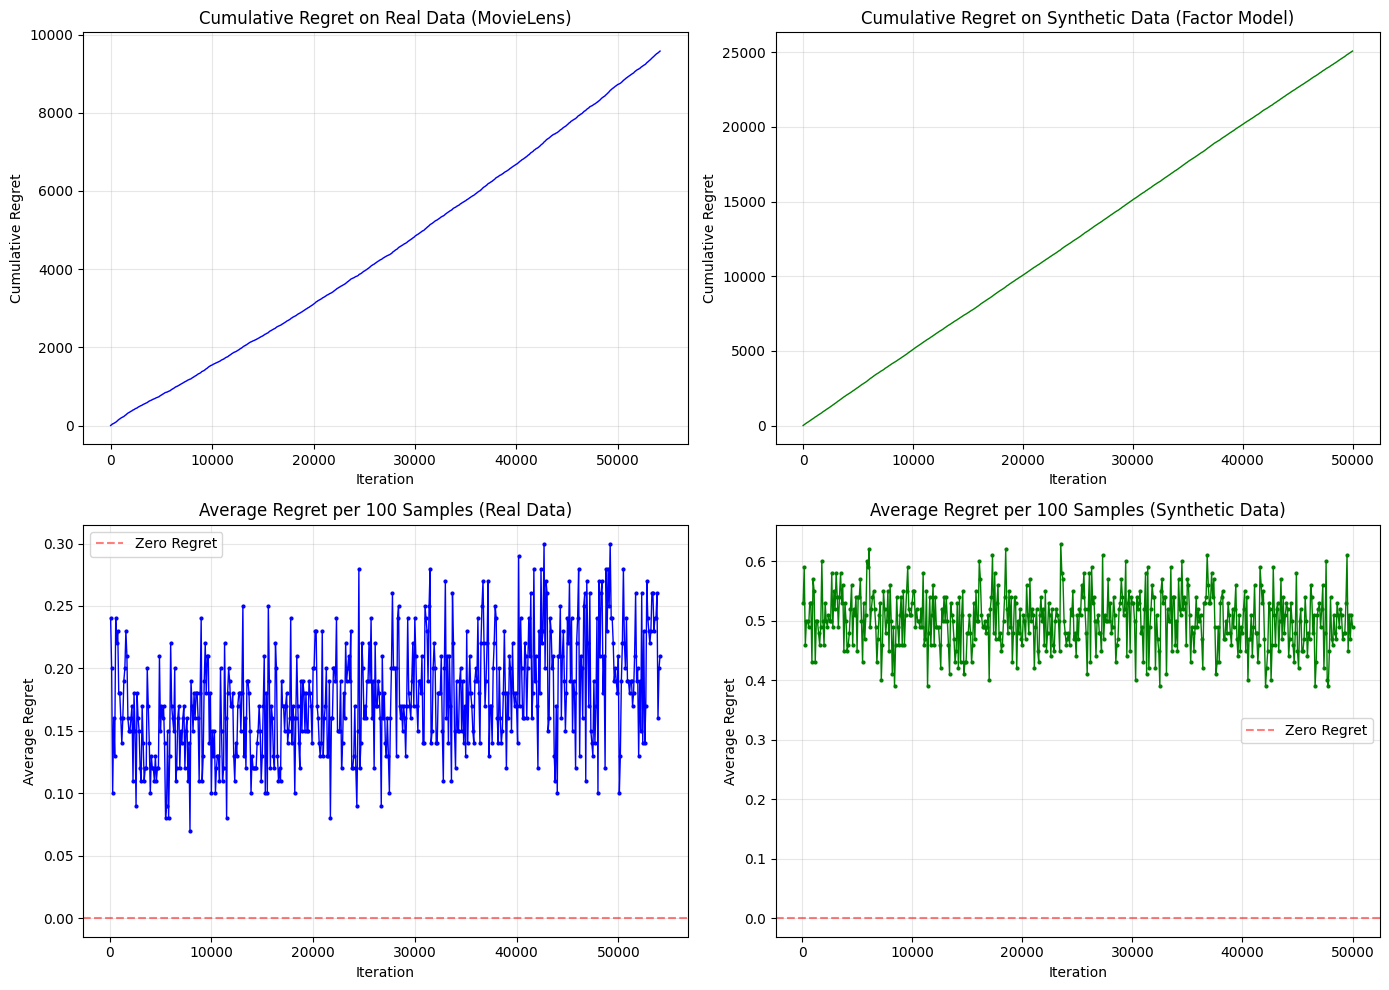


REGRET ANALYSIS SUMMARY

--- Real Data (MovieLens) ---
Total interactions: 54149
Total cumulative regret: 9580.00
Average regret per interaction: 0.1769
Final 100-sample avg regret: 0.2100

--- Synthetic Data (Factor Model) ---
Total interactions: 50000
Total cumulative regret: 25075.00
Average regret per interaction: 0.5015
Final 100-sample avg regret: 0.4900


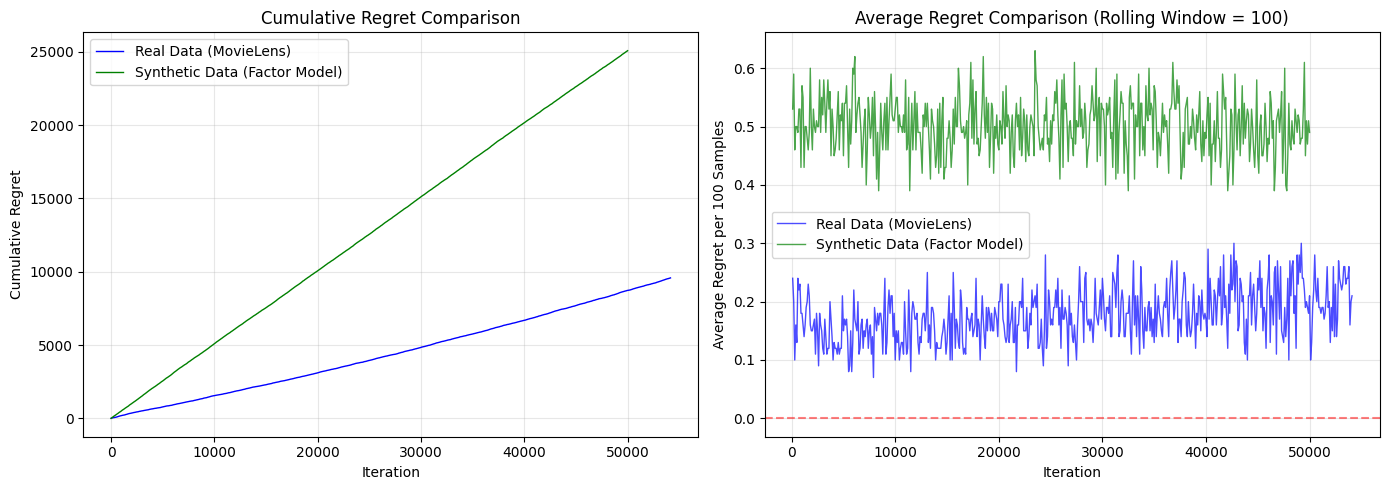

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# Part 1: Run KNN Bandit on Synthetic Data
# ============================================================

# Generate synthetic data with factor model
probs, likes, user_factors_df, movie_factors_df, interactions_df = simulate_like_dislike_matrix()

# Rename columns to match expected format
synthetic_ratings = interactions_df.rename(columns={
    'user_id': 'UserID',
    'movie_id': 'MovieID',
    'liked': 'binary_rating'
})

# Initialize and run KNN Bandit on synthetic data
print("Running KNN Bandit on synthetic data...")
knn_bandit_synthetic = KNNBandit(k=10, ratings=synthetic_ratings)
recommendations_synthetic = knn_bandit_synthetic.simulate(n_simulations=50000)
print(f"Synthetic simulation completed with {len(recommendations_synthetic)} valid interactions.")

# ============================================================
# Part 2: Calculate Regret Metrics
# ============================================================

def calculate_regret_metrics(recommendations, optimal_reward=1):
    """
    Calculate cumulative regret and average regret per window.
    
    Args:
        recommendations: List of [user_id, item_id, reward]
        optimal_reward: The optimal reward (1 for binary rewards)
    
    Returns:
        cumulative_regret: Array of cumulative regret over time
        avg_regret_per_window: Average regret calculated every 100 samples
    """
    rewards = np.array([rec[2] for rec in recommendations])
    n = len(rewards)
    
    # Instantaneous regret (optimal - actual)
    instant_regret = optimal_reward - rewards
    
    # Cumulative regret
    cumulative_regret = np.cumsum(instant_regret)
    
    # Average regret per 100 samples
    window_size = 100
    n_windows = n // window_size
    avg_regret_per_window = []
    window_positions = []
    
    for i in range(n_windows):
        start_idx = i * window_size
        end_idx = (i + 1) * window_size
        window_regret = np.mean(instant_regret[start_idx:end_idx])
        avg_regret_per_window.append(window_regret)
        window_positions.append(end_idx)
    
    return cumulative_regret, avg_regret_per_window, window_positions

# Calculate metrics for real data
cumulative_regret_real, avg_regret_real, windows_real = calculate_regret_metrics(recommendations)

# Calculate metrics for synthetic data
cumulative_regret_synthetic, avg_regret_synthetic, windows_synthetic = calculate_regret_metrics(recommendations_synthetic)

# ============================================================
# Part 3: Plotting
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Cumulative Regret - Real Data
ax1 = axes[0, 0]
ax1.plot(cumulative_regret_real, color='blue', linewidth=1)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Cumulative Regret')
ax1.set_title('Cumulative Regret on Real Data (MovieLens)')
ax1.grid(True, alpha=0.3)

# Plot 2: Cumulative Regret - Synthetic Data
ax2 = axes[0, 1]
ax2.plot(cumulative_regret_synthetic, color='green', linewidth=1)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Cumulative Regret')
ax2.set_title('Cumulative Regret on Synthetic Data (Factor Model)')
ax2.grid(True, alpha=0.3)

# Plot 3: Average Regret per 100 Samples - Real Data
ax3 = axes[1, 0]
ax3.plot(windows_real, avg_regret_real, color='blue', linewidth=1, marker='o', markersize=2)
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Average Regret')
ax3.set_title('Average Regret per 100 Samples (Real Data)')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Zero Regret')
ax3.legend()

# Plot 4: Average Regret per 100 Samples - Synthetic Data
ax4 = axes[1, 1]
ax4.plot(windows_synthetic, avg_regret_synthetic, color='green', linewidth=1, marker='o', markersize=2)
ax4.set_xlabel('Iteration')
ax4.set_ylabel('Average Regret')
ax4.set_title('Average Regret per 100 Samples (Synthetic Data)')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Zero Regret')
ax4.legend()

plt.tight_layout()
plt.show()

# ============================================================
# Part 4: Print Summary Statistics
# ============================================================
print("\n" + "="*60)
print("REGRET ANALYSIS SUMMARY")
print("="*60)

print("\n--- Real Data (MovieLens) ---")
print(f"Total interactions: {len(recommendations)}")
print(f"Total cumulative regret: {cumulative_regret_real[-1]:.2f}")
print(f"Average regret per interaction: {cumulative_regret_real[-1]/len(recommendations):.4f}")
print(f"Final 100-sample avg regret: {avg_regret_real[-1]:.4f}")

print("\n--- Synthetic Data (Factor Model) ---")
print(f"Total interactions: {len(recommendations_synthetic)}")
print(f"Total cumulative regret: {cumulative_regret_synthetic[-1]:.2f}")
print(f"Average regret per interaction: {cumulative_regret_synthetic[-1]/len(recommendations_synthetic):.4f}")
print(f"Final 100-sample avg regret: {avg_regret_synthetic[-1]:.4f}")

# ============================================================
# Part 5: Combined Comparison Plot
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Combined Cumulative Regret
ax1 = axes[0]
ax1.plot(cumulative_regret_real, color='blue', linewidth=1, label='Real Data (MovieLens)')
ax1.plot(cumulative_regret_synthetic, color='green', linewidth=1, label='Synthetic Data (Factor Model)')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Cumulative Regret')
ax1.set_title('Cumulative Regret Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Combined Average Regret per 100 Samples
ax2 = axes[1]
ax2.plot(windows_real, avg_regret_real, color='blue', linewidth=1, label='Real Data (MovieLens)', alpha=0.7)
ax2.plot(windows_synthetic, avg_regret_synthetic, color='green', linewidth=1, label='Synthetic Data (Factor Model)', alpha=0.7)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Average Regret per 100 Samples')
ax2.set_title('Average Regret Comparison (Rolling Window = 100)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
